In [1]:
import numpy 
import pandas 
from sklearn.linear_model import LinearRegression
import seaborn as sns 

import plotly.io as pio
import plotly.express as px 
pio.renderers.default = 'jupyterlab'

from scipy.stats import pearsonr
import networkx as nx
import matplotlib.pyplot as plt

import dowhy
from castle.algorithms import PC
from utils import adjacency_to_graph, plot_graph


You can use `os.environ['CASTLE_BACKEND'] = backend` to set the backend(`pytorch` or `mindspore`).
You are using ``pytorch`` as the backend.


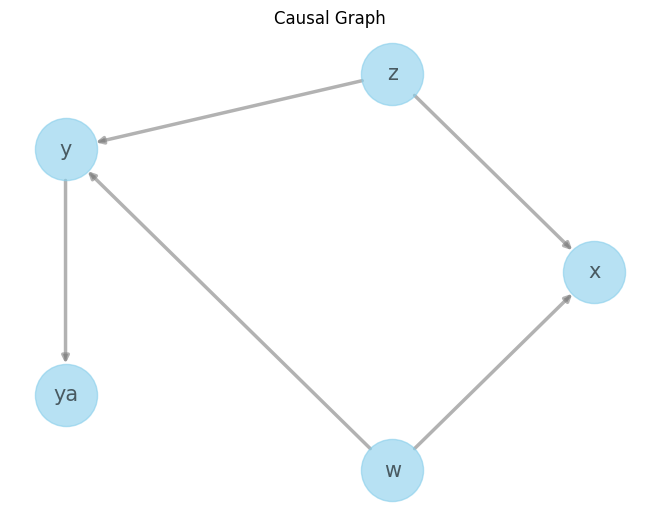

In [2]:
N = 10000
rho_wx = 0.5
rho_wy = 0.5
rho_zx = 0.5
rho_zy = 0.5
eta = 1

w = numpy.random.normal(0,1,N)
z = numpy.random.normal(0,1,N) 
x = rho_wx * w + rho_zx * z + eta * numpy.random.normal(0,1,N)
y = rho_wy * w + rho_zy * z + eta * numpy.random.normal(0,1,N)
ya = 0.5 * ( y) + eta * numpy.random.normal(0,1,N)

df = pandas.DataFrame({'z':z,'w':w,'x':x,'y':y, 'ya': ya})
columns = ['x','z','y', 'ya','w']
df = df[columns]

pc = PC(alpha = 0.001)
pc.learn(df)
graph = adjacency_to_graph( pc.causal_matrix, df.columns )
plot_graph(graph)

In [13]:
df.corr()

,x,z,y,ya,w
x,1.000000,0.403487,0.336631,0.167371,0.410236
z,0.403487,1.000000,0.421967,0.201421,-0.001918
y,0.336631,0.421967,1.000000,0.526711,0.405172
ya,0.167371,0.201421,0.526711,1.000000,0.217203
w,0.410236,-0.001918,0.405172,0.217203,1.000000


## The do-nots

Suppose ya is our variable of interest, and we go the ML route of just estimating it from all the other features.

In [3]:
from sklearn.linear_model import LassoCV

In [4]:
target = 'y'
X = df.drop(columns = [target])
model = LassoCV()
model.fit(X,df[target])
_ = [ print( feature, ': ', round(coef,2) ) for feature,coef in zip(X.columns,model.coef_) ]

x :  0.0
z :  0.42
ya :  0.4
w :  0.39


##### Why does lasso correctly drop X as a feature?

For the maths nerds, the reason is [FWL theorem](https://en.wikipedia.org/wiki/Frisch%E2%80%93Waugh%E2%80%93Lovell_theorem). While linear regressions will generally have the same effect of conditioning in linear models, you have to be careful when the data is nonlinear.

## The do-why

Using a structural causal model we can estimate the causal effects by using the information within the underlying cuasal graph.

In [5]:
from dowhy import gcm

causal_model = gcm.StructuralCausalModel(graph)
gcm.auto.assign_causal_mechanisms(causal_model, df)

gcm.fit(causal_model, df)

Fitting causal mechanism of node w: 100%|████████| 5/5 [00:00<00:00, 233.40it/s]


In [6]:
def get_effect_distribution( causal_model, change_var, change =1 ):
    r = []
    for n in range(500):
        samples = gcm.interventional_samples(causal_model,
                                             {change_var: lambda x: x + change },
                                             num_samples_to_draw=10000)
        vals = samples.mean()
        r.append(vals.to_dict())

    dist_df = pandas.DataFrame(r)
    dist_df = dist_df - df.mean()
    return dist_df

In [10]:
average_effects = get_effect_distribution( causal_model, 'y' )

In [11]:
average_effects.mean()

w    -0.000123
x     0.000264
y     1.000669
ya    0.508743
z     0.001057
dtype: float64

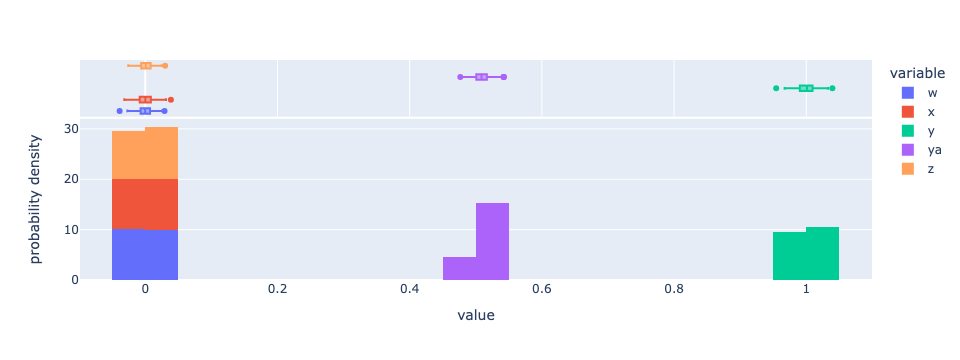

In [12]:
px.histogram( average_effects, marginal = 'box', histnorm = 'probability density')


## Homework:

- Linear models are cute, but what about the real world?
    - Task 1: You will learn about [meta-learners](https://matheusfacure.github.io/python-causality-handbook/21-Meta-Learners.html). This way you will be able to use your favourite ML models to estimate causal effects.
    - Task 2: You will also learn about [doubleML](https://docs.doubleml.org/stable/index.html), which allow us to combine ML estimators to generate unbiased causal effects.
 

      
<br>

- Nomenclature: get familiar with the following terms:
    * ATE: Average Treatment Effect
    - HTE: Heterogeneous Treatment Effect
    - ITE: Individual Treatment Effect
    - CATE: Conditional Average Treatment Effect

<br>

- And with the following classical methods:
    - Backdoor adjustment
    - Frontdoor adjustment
    - PSM: propensity score matching
    - IPW: inverse probability weighting
    - Instrumental Variables
 
      
<br>

 - Optimization: so if we know the expected effect of applying a number of treatments, that means I can design the best treatment for each individual! How would you construct an algorithm that takes in a causal graph, an individual, the preferred treatment and its expected effect?